<a href="https://colab.research.google.com/github/BenRyan-8/Forecasting_Analysis/blob/main/CandyProductionCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Nonseasonal Time Series Analysis


> Ben Ryan - C22513316

> Abdolhmed Bashara - C22406056





##US candy production by month, as a percent of 2012 production. 2005-2017

> Source: Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Sugar and confectionery product [IPG3113N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPG3113N, October 13, 2017.






###Dataset Overview:

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories. This dataset tracks industrial production of Candy every month from January 2005 to December 2016

Import necessary libraries

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
data_url= 'https://raw.githubusercontent.com/BenRyan-8/candy_sales/main/candy_production.csv'
df = pd.read_csv(data_url)
df= df[['date','data']]

df.head()

,date,data
0,01/01/2005,124.5687
1,01/02/2005,123.9260
2,01/03/2005,107.2575
3,01/04/2005,106.8015
4,01/05/2005,111.4551


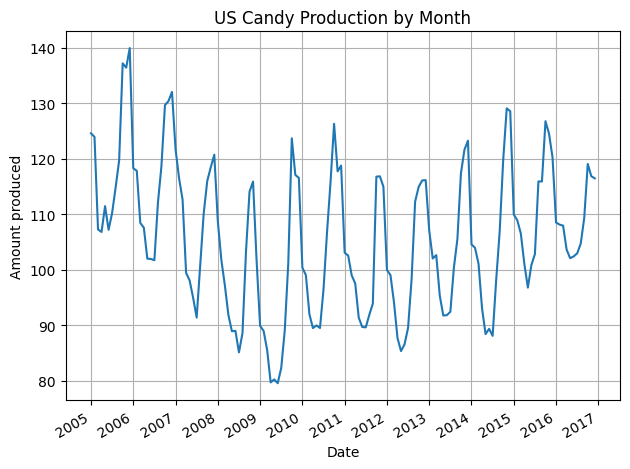

In [6]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Amount produced')
ax.set_title('US Candy Production by Month')
plt.xticks(np.arange(0, 145, 12),[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])
plt.grid(True)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/F01_CP.png', dpi=1000)


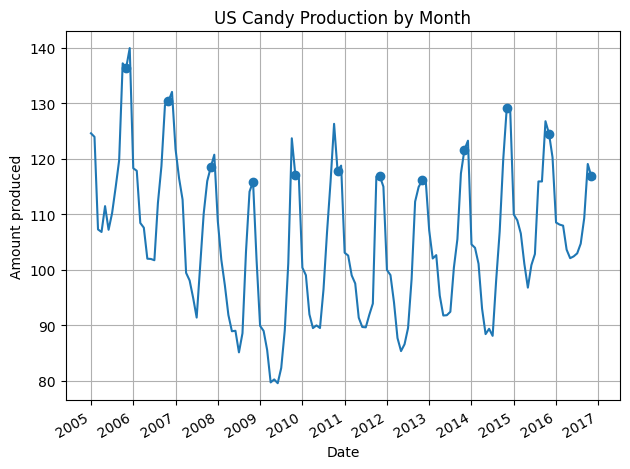

In [7]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'], markevery=np.arange(10, 145, 12), marker='o')
ax.set_xlabel('Date')
ax.set_ylabel('Amount produced')
ax.set_title('US Candy Production by Month')
plt.xticks(np.arange(0, 145, 12),[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])
plt.grid(True)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/F01_CP.png', dpi=1000)


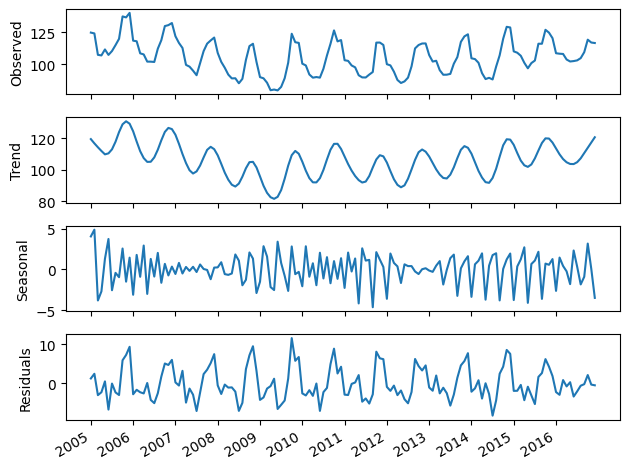

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

advanced_decomposition = STL(df.data, period=4).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')


plt.xticks(np.arange(0, 144, 12),[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH01_F02_jj.png', dpi=300)

Stationarity test

In [9]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(df['data'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.0248382912326663
p-value: 0.2757896702057341


In [10]:
candy_diff = np.diff(df['data'], n=1)

ADF_result = adfuller(candy_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')


ADF Statistic: -4.014266764107551
p-value: 0.0013376213910729748


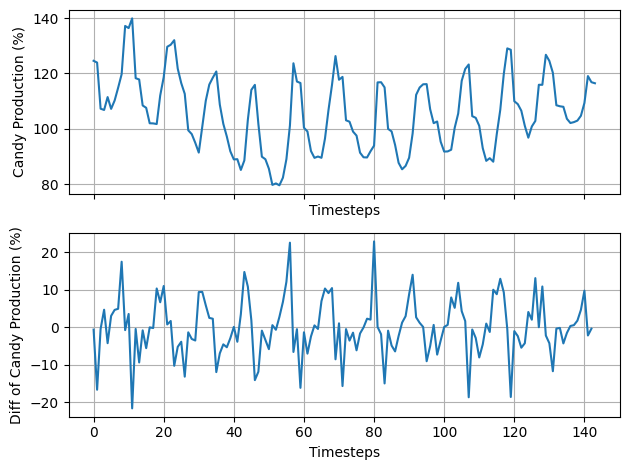

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['data'])
ax1.set_xlabel('Timesteps')
ax1.set_ylabel('Candy Production (%)')
ax1.grid(True)

ax2.plot(candy_diff)
ax2.set_xlabel('Timesteps')
ax2.set_ylabel('Diff of Candy Production (%)')
plt.grid(True)

plt.tight_layout()

plt.savefig('figures/fig2_USGP.png', dpi=1000)

In [12]:
def optimize_ARIMA(train, order_list, d) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(train, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [13]:
def optimize_SARIMA(train, order_list, d, D, s) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                train,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
        nParams=sum(order)
        aic = model.aic
        results.append([nParams, order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['# of Params','(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [14]:
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
s = 12

ARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['data'][:-12]

ARIMA_result_df = optimize_SARIMA(train, ARIMA_order_list, d, D, s)
ARIMA_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,# of Params,"(p,q,P,Q)",AIC
0,18,"(10, 8, 0, 0)",804.616048
1,21,"(11, 10, 0, 0)",805.162348
2,20,"(9, 11, 0, 0)",805.553147
3,17,"(9, 8, 0, 0)",805.563181
4,21,"(9, 12, 0, 0)",805.605854
...,...,...,...
164,3,"(3, 0, 0, 0)",924.544757
165,4,"(4, 0, 0, 0)",925.079245
166,2,"(1, 1, 0, 0)",925.490700
167,2,"(2, 0, 0, 0)",925.938957


In [15]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

train = df['data'][:-12]

d = 1
D = 1
s = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,# of Params,"(p,q,P,Q)",AIC
0,3,"(1, 1, 0, 1)",698.858536
1,2,"(0, 1, 0, 1)",698.975742
2,3,"(0, 2, 0, 1)",699.625410
3,4,"(0, 3, 0, 1)",700.264528
4,2,"(1, 0, 0, 1)",700.729908
...,...,...,...
250,1,"(1, 0, 0, 0)",746.149318
251,2,"(0, 2, 0, 0)",746.932298
252,2,"(2, 0, 0, 0)",748.096329
253,0,"(0, 0, 0, 0)",748.318053


In [16]:
ARIMA_model = SARIMAX(train, order=(10,1,8), simple_differencing=False)
ARIMA_model_fit = ARIMA_model.fit(disp=False)

print(ARIMA_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                  132
Model:              SARIMAX(10, 1, 8)   Log Likelihood                -386.334
Date:                Fri, 17 May 2024   AIC                            810.668
Time:                        18:05:12   BIC                            865.297
Sample:                             0   HQIC                           832.866
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7477      0.394     -1.897      0.058      -1.520       0.025
ar.L2          0.3111      0.162      1.919      0.055      -0.007       0.629
ar.L3         -0.1491      0.151     -0.991      0.3

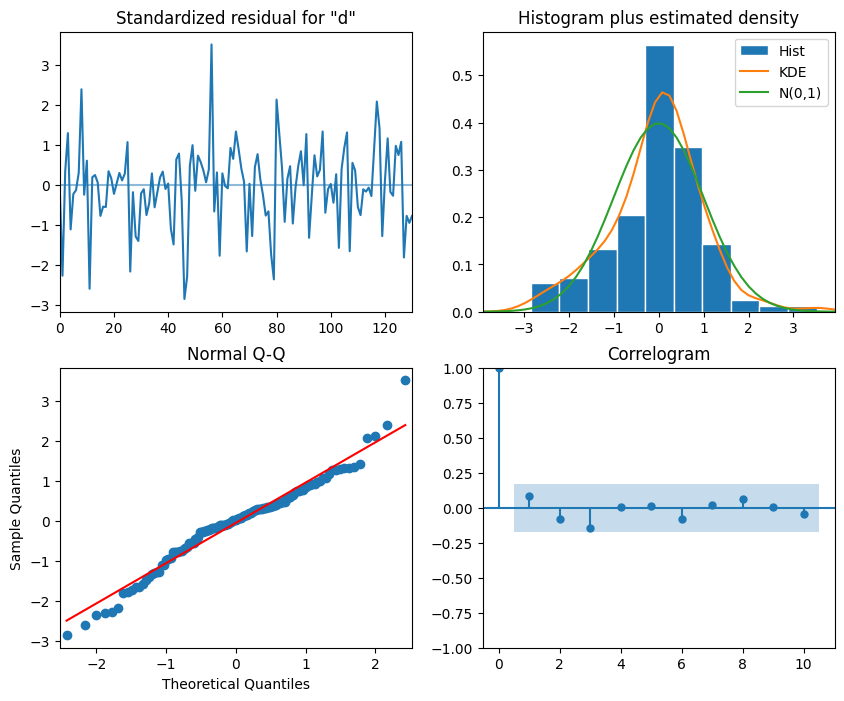

In [17]:
ARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH08_F09_peixeiro.png', dpi=300)

In [18]:
residuals = ARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [19]:
test = df.iloc[-12:]

test['naive_seasonal'] = df['data'].iloc[120:132].values
test

,date,data,naive_seasonal
132,01/01/2016,108.5041,109.9525
133,01/02/2016,108.1308,108.9073
134,01/03/2016,107.9417,106.5261
135,01/04/2016,103.6179,101.0631
136,01/05/2016,102.0816,96.7802
137,01/06/2016,102.4044,100.8339
138,01/07/2016,102.9512,102.8290
139,01/08/2016,104.6977,115.9030
140,01/09/2016,109.3191,115.8964
141,01/10/2016,119.0502,126.7440


In [20]:
ARIMA_pred = ARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred
132,01/01/2016,108.5041,109.9525,111.414197
133,01/02/2016,108.1308,108.9073,106.208633
134,01/03/2016,107.9417,106.5261,99.939105
135,01/04/2016,103.6179,101.0631,97.852620
136,01/05/2016,102.0816,96.7802,94.536349
137,01/06/2016,102.4044,100.8339,94.361822
138,01/07/2016,102.9512,102.8290,94.451264
139,01/08/2016,104.6977,115.9030,104.540754
140,01/09/2016,109.3191,115.8964,112.072514
141,01/10/2016,119.0502,126.7440,122.518087


In [21]:
SARIMA_model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,12), simple_differencing=False)
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                  132
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -345.429
Date:                            Fri, 17 May 2024   AIC                            698.859
Time:                                    18:05:14   BIC                            709.975
Sample:                                         0   HQIC                           703.373
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3846      0.302      1.273      0.203      -0.207       0.977
ma.L1         -0.6742      0.236   

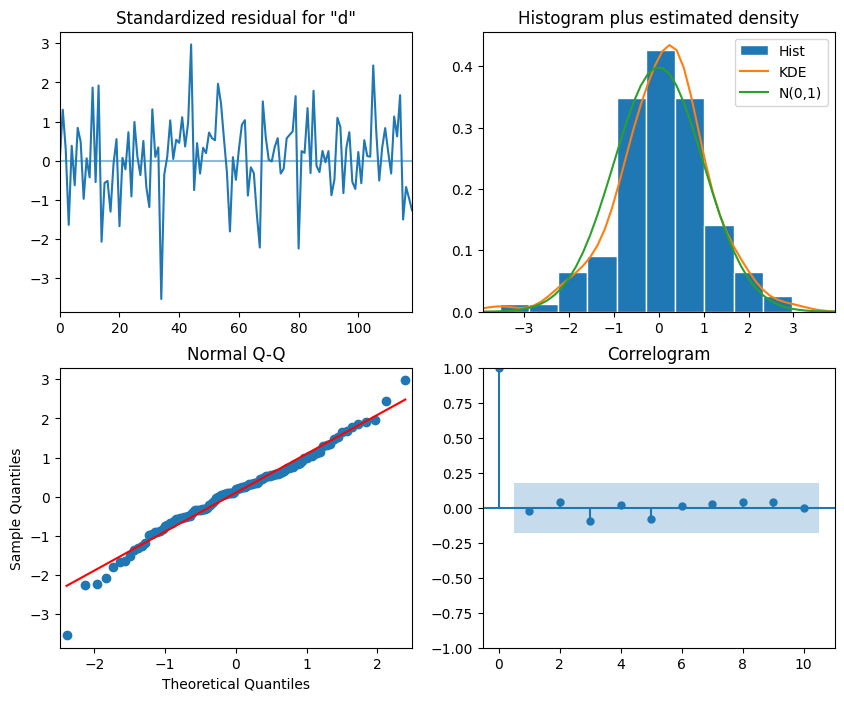

In [22]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

plt.savefig('figures/CH08_F12_peixeiro.png', dpi=300)

In [23]:
residuals = SARIMA_model_fit.resid

lbvalue, pvalue = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(pvalue)

lb_pvalue


In [24]:
SARIMA_pred = SARIMA_model_fit.get_prediction(132, 143).predicted_mean

test['SARIMA_pred'] = SARIMA_pred
test

,date,data,naive_seasonal,ARIMA_pred,SARIMA_pred
132,01/01/2016,108.5041,109.9525,111.414197,107.455635
133,01/02/2016,108.1308,108.9073,106.208633,106.152697
134,01/03/2016,107.9417,106.5261,99.939105,101.450061
135,01/04/2016,103.6179,101.0631,97.852620,96.310827
136,01/05/2016,102.0816,96.7802,94.536349,93.925709
137,01/06/2016,102.4044,100.8339,94.361822,93.756845
138,01/07/2016,102.9512,102.8290,94.451264,94.641470
139,01/08/2016,104.6977,115.9030,104.540754,102.687739
140,01/09/2016,109.3191,115.8964,112.072514,110.400087
141,01/10/2016,119.0502,126.7440,122.518087,122.966566


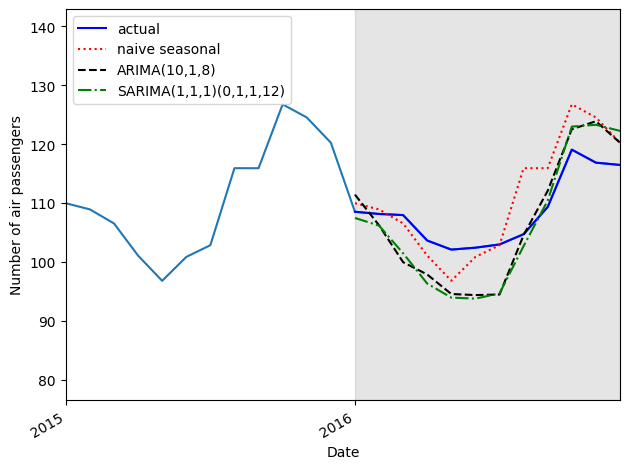

In [25]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(10,1,8)')
ax.plot(test['SARIMA_pred'], 'g-.', label='SARIMA(1,1,1)(0,1,1,12)')

ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')
ax.axvspan(132, 143, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 145, 12), np.arange(2005, 2018, 1))
ax.set_xlim(120, 143)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH08_F13_peixeiro.png', dpi=300)

In [26]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [27]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])
mape_SARIMA = mape(test['data'], test['SARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA, mape_SARIMA)

3.8062443501213523 4.648388280049712 4.752696735749492


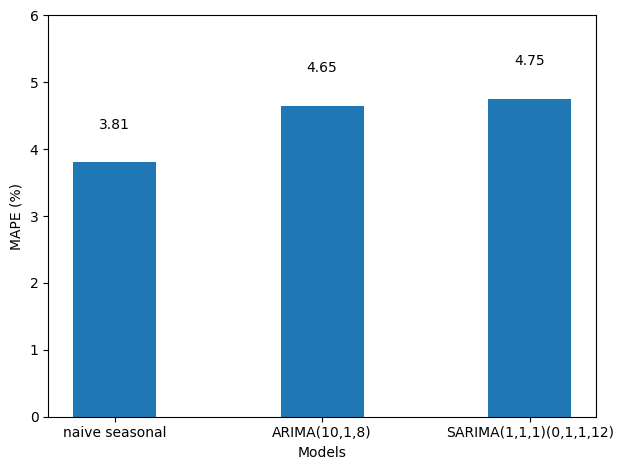

In [28]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(10,1,8)', 'SARIMA(1,1,1)(0,1,1,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 6)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.5, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH08_F14_peixeiro.png', dpi=300)